In [1]:
from casadi import *
import numpy as np
import pandas as pd
from numpy.linalg import norm
import sADMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

raw = pd.read_csv("CCPP.csv") 
# scale data to have zero mean and std = 1
scaler = StandardScaler()
data = scaler.fit_transform(raw)

x = data[0:400,0:4]
#x['bias'] = np.ones(x.shape[0])
#x = x.to_numpy()

y = data[0:400,4]
#y = y.to_numpy()
y = y.reshape(-1,1)


nu = 4                     # no. of inputs
ny = 1                     # no. of outputs
nn = 5                     # no. of neurons 
nw =  nu*nn+nn+ny*nn+ny    # no. of parameters

# Solve centralized optimization
solver,nlp = sADMM.MLP_regression(x,y,nn)
Primal,Dual,f = sADMM.solvenlp(solver,nlp)
w_opt = Primal.full()

# Prediction
y_pred0 = sADMM.MLP(x,w_opt,4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

ModuleNotFoundError: No module named 'sADMM'

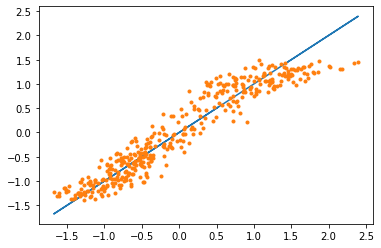

In [6]:

N = 4
nData,ny = y.shape
nblock = round(nData/N)

# Split data into N data chunks
x1 = x[0*nblock:1*nblock,:]
x2 = x[1*nblock:2*nblock,:]
x3 = x[2*nblock:3*nblock,:] 
x4 = x[3*nblock:4*nblock,:]

y1 = y[0*nblock:1*nblock,:] 
y2 = y[1*nblock:2*nblock,:]
y3 = y[2*nblock:3*nblock,:] 
y4 = y[3*nblock:4*nblock,:]

rho = 100 # penalty term in the Augmented Lagrangian


solver0,nlp0 = sADMM.consensus_reg_nn(nw,N,rho)

solver1,nlp1 = sADMM.consensus_subproblem_nn(x1,y1,nn,rho)
solver2,nlp2 = sADMM.consensus_subproblem_nn(x2,y2,nn,rho)
solver3,nlp3 = sADMM.consensus_subproblem_nn(x3,y3,nn,rho)
solver4,nlp4 = sADMM.consensus_subproblem_nn(x4,y4,nn,rho)

solvers = [solver1,solver2,solver3,solver4]
nlps = [nlp1,nlp2,nlp3,nlp4]

x0_opt = w_opt*0.0    # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt = sADMM.ADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0002,MaxIter=30)

# Prediction
y_pred0 = sADMM.MLP(x,x0_opt.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

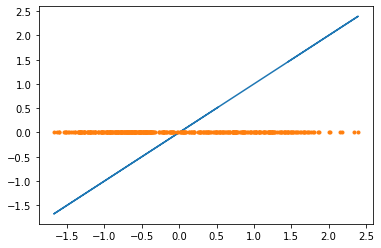

In [7]:
x0_opt = w_opt*0.5    # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt = sADMM.sADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0002,MaxIter=30)

# Prediction
y_pred0 = sADMM.MLP(x,x0_opt.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

In [8]:
print(x_opt[0])
print(x_opt[1])
print(x_opt[2])
print(x0_opt)
print(Primal)

[0.00143606, 0.00167677, 0.00203598, 0.00257254, 0.00337458, 0.00144135, 0.00165981, 0.0019858, 0.00247275, 0.00320063, -0.00222644, -0.00232984, -0.0024847, -0.00271659, -0.00306379, -0.000730113, -0.000810853, -0.000931971, -0.00111353, -0.00138555, 0.000293065, 0.000289438, 0.000283563, 0.000274322, 0.000260045, 0.0257593, 0.025264, 0.0245225, 0.0234128, 0.0217517, 0.0233887]
[3.86367e-05, -0.000440536, -0.00115749, -0.00223019, -0.00383514, 0.0002241, -0.000176159, -0.000775043, -0.0016711, -0.00301177, -0.00160096, -0.00138043, -0.00105053, -0.000557002, 0.000181339, -0.000185344, -1.65458e-06, 0.000273102, 0.000684109, 0.00129897, 0.000297352, 0.000297344, 0.000297271, 0.000297103, 0.000296792, -0.00744746, -0.00634118, -0.00468604, -0.00220969, 0.00149529, -0.00115762]
[0.000498484, 0.000250272, -0.000120721, -0.000675227, -0.00150402, 0.000541045, 0.000298221, -6.47173e-05, -0.000607186, -0.00141799, -0.00179108, -0.00167048, -0.00149023, -0.00122083, -0.000818166, -0.000327318

In [28]:
import numpy as np

def c2d(tau1,tau2,tauZ,k=1,Ts=1):
    a1 = np.exp(-Ts/tau1) + np.exp(-Ts/tau2)
    a2 = -np.exp(-Ts/tau1)*np.exp(-Ts/tau2)
    b1 = k*(1 + (tauZ-tau1)/(tau1-tau2)*np.exp(-Ts/tau1) + (tau2-tauZ)/(tau1-tau2)*np.exp(-Ts/tau2))
    b2 = k*(np.exp(-Ts*(1/tau1 + 1/tau2)) + (tauZ-tau1)/(tau1-tau2)*np.exp(-Ts/tau2) + (tau2-tauZ)/(tau1-tau2)*np.exp(-Ts/tau1))
    return a1,a2,b1,b2

tau1 = 150
tau2 = 50
tauZ = -10
k = 1
a1,a2,b1,b2 = c2d(tau1,tau2,tauZ)
print(a1,a2,b1,b2)
print((1-a1-a2)-(b1+b2))

1.9735541795617897 -0.973685749353145 -0.0012496060240020368 0.0013811758153572384
1.1102230246251565e-16
